In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

In [14]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("EI:",ei)

Upper bound is [ 2.61559521  0.          0.77040278 -1.44729289  0.89942748  0.76481487]
Lower bound is [ 2.455043   -0.16505741  0.60472325 -1.59876604  0.72446971  0.58743551]
pdf upper is [0.01304164 0.39894228 0.29650276 0.13997844 0.26622235 0.29777729]
cdf upper is [0.9955464  0.5        0.7794695  0.07390745 0.81578749 0.7778091 ]
pdf lower is [0.01959352 0.39354475 0.33227789 0.11113996 0.30685906 0.33571967]
cdf lower is [0.99295661 0.4344494  0.72731855 0.0549363  0.76561129 0.72154437]
EI: [-0.48181523  0.27222271 -0.44164842 -1.33454245 -0.60791045 -0.3945734 ]


In [15]:
#Test calc_ei_adv (to compare with hand calcs)
import numpy as np
import torch
er_best = 1.0
mu = torch.tensor([3])
y_exp2 = np.array([4])
pred_var = torch.tensor([1])
print("EI:",calc_ei_advanced(er_best,mu,pred_var,y_exp2))

Upper bound is [2.]
Lower bound is [0.]
pdf upper is [0.05399097]
cdf upper is [0.97724987]
pdf lower is [0.39894228]
cdf lower is [0.5]
EI: [-0.79259589]


Improvement is [-5.2035183e-05]


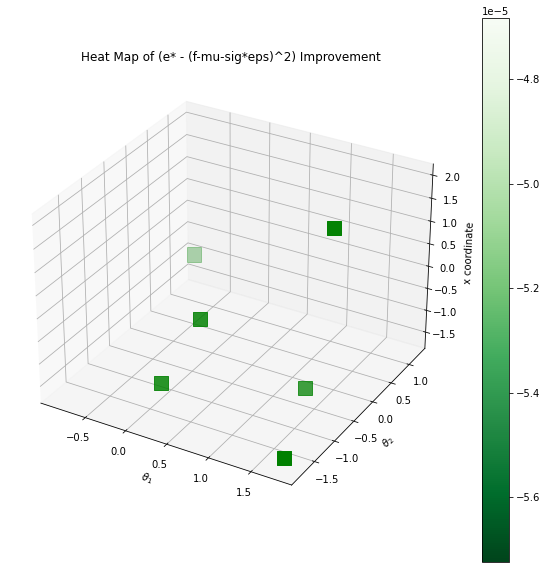

None


In [9]:
eps = -5
I = improvement(er_best,mu,pred_var,y_exp2,eps)
print("Improvement is", I)
print(improvement_plot(test_p,I))

Improvement: [array([-5.2035183e-05]), array([-0.00475064]), array([-0.11176728]), array([-0.60791585]), array([-0.48540264]), array([0.27435801]), array([0.05526508]), array([-0.01819467]), array([-0.00152379]), array([-2.23007927e-05])]


Text(0, 0.5, 'Improvement')

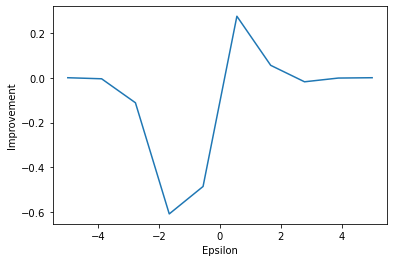

In [10]:
EPS = np.linspace(-5,5,10)
I_test = []
for i in range(len(EPS)):
    I_i = I = improvement(er_best,mu,pred_var,y_exp2,EPS[i])
    I_test.append(I_i)
print("Improvement:", I_test) 

from matplotlib import pyplot as plt    
plt.plot(EPS,I_test)
plt.xlabel("Epsilon")
plt.ylabel("Improvement")

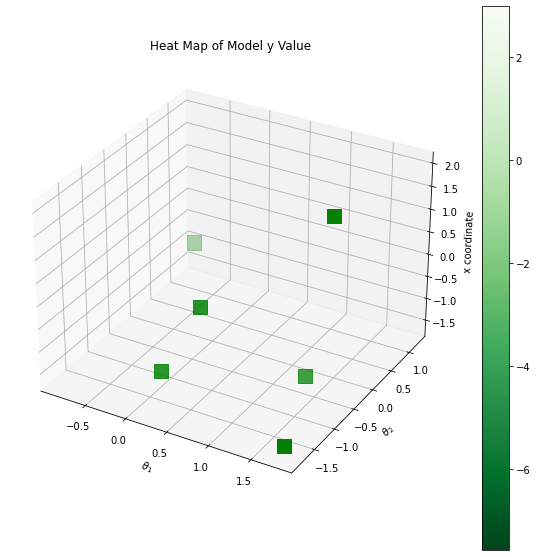

None


In [11]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))

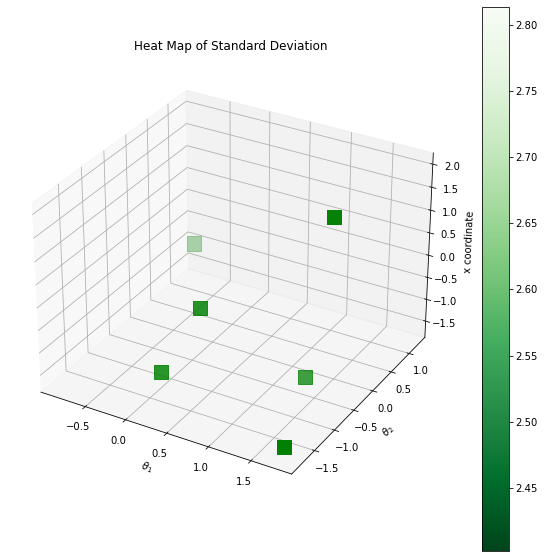

None


In [12]:
print(stdev_plotter_adv(test_p, model_stdev))

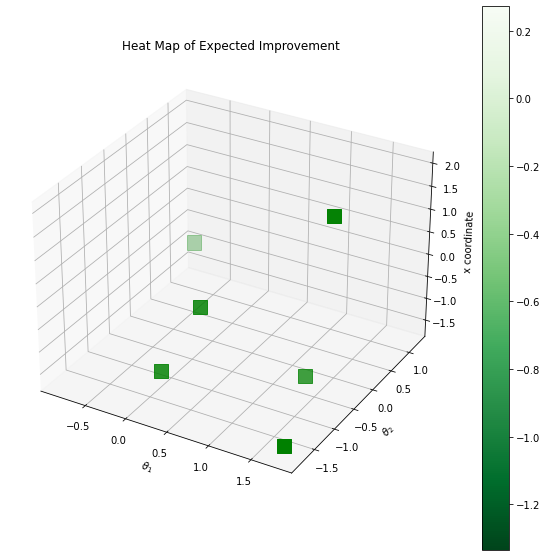

None


In [13]:
print(ei_plotter_adv(test_p, ei))